<a href="https://colab.research.google.com/github/nikitha12323/PRODIGY_GA_01/blob/main/PRODIGY_GA_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Content shape: torch.Size([1, 3, 512, 512]) Style shape: torch.Size([1, 3, 512, 512])
Starting optimization...
Step [10/500]  Total Loss: 4.8827e+02
Step [20/500]  Total Loss: 1.9218e+02
Step [30/500]  Total Loss: 9.4799e+01
Step [40/500]  Total Loss: 5.3914e+01
Step [50/500]  Total Loss: 3.4564e+01
Step [60/500]  Total Loss: 2.4389e+01
Step [70/500]  Total Loss: 1.8652e+01
Step [80/500]  Total Loss: 1.5908e+01
Step [90/500]  Total Loss: 1.4802e+01
Step [100/500]  Total Loss: 1.2451e+01
Saved intermediate image: nst_outputs/nst_step_100.png


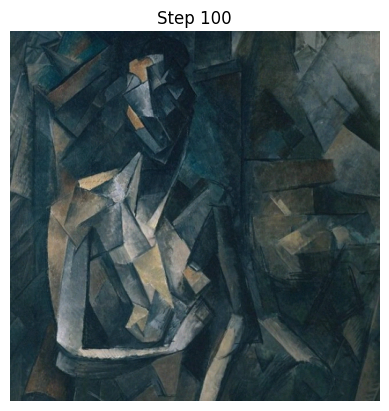

Step [110/500]  Total Loss: 1.1014e+01
Step [120/500]  Total Loss: 1.1027e+01
Step [130/500]  Total Loss: 1.3463e+01
Step [140/500]  Total Loss: 1.1344e+01
Step [150/500]  Total Loss: 9.7603e+00
Step [160/500]  Total Loss: 1.0380e+01
Step [170/500]  Total Loss: 1.2492e+01
Step [180/500]  Total Loss: 1.1494e+01
Step [190/500]  Total Loss: 8.8232e+00
Step [200/500]  Total Loss: 8.8950e+00
Saved intermediate image: nst_outputs/nst_step_200.png


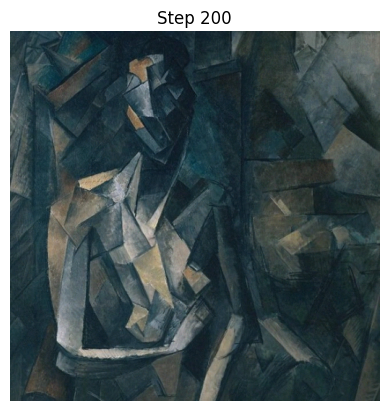

Step [210/500]  Total Loss: 1.6234e+01
Step [220/500]  Total Loss: 1.2556e+01
Step [230/500]  Total Loss: 1.0591e+01
Step [240/500]  Total Loss: 9.8495e+00
Step [250/500]  Total Loss: 8.6490e+00
Step [260/500]  Total Loss: 1.0947e+01
Step [270/500]  Total Loss: 1.4494e+01
Step [280/500]  Total Loss: 1.0949e+01
Step [290/500]  Total Loss: 1.0233e+01
Step [300/500]  Total Loss: 9.1858e+00
Saved intermediate image: nst_outputs/nst_step_300.png


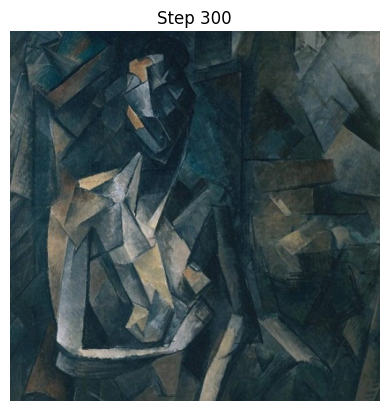

Step [310/500]  Total Loss: 9.9023e+00
Step [320/500]  Total Loss: 1.0763e+01
Step [330/500]  Total Loss: 1.0546e+01
Step [340/500]  Total Loss: 1.0876e+01
Step [350/500]  Total Loss: 1.1610e+01
Step [360/500]  Total Loss: 1.0992e+01
Step [370/500]  Total Loss: 1.1146e+01
Step [380/500]  Total Loss: 9.8058e+00
Step [390/500]  Total Loss: 9.1197e+00
Step [400/500]  Total Loss: 9.6063e+00
Saved intermediate image: nst_outputs/nst_step_400.png


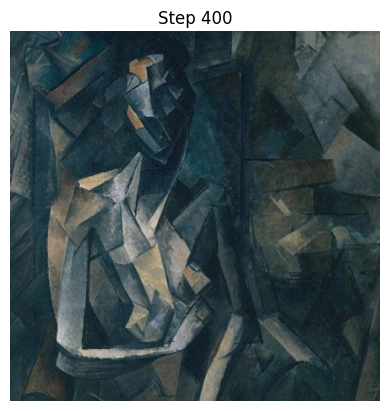

Step [410/500]  Total Loss: 1.2650e+01
Step [420/500]  Total Loss: 1.4370e+01
Step [430/500]  Total Loss: 1.2203e+01
Step [440/500]  Total Loss: 1.0319e+01
Step [450/500]  Total Loss: 1.0199e+01
Step [460/500]  Total Loss: 1.1842e+01
Step [470/500]  Total Loss: 1.1378e+01
Step [480/500]  Total Loss: 1.3645e+01
Step [490/500]  Total Loss: 1.4252e+01
Step [500/500]  Total Loss: 1.4388e+01
Saved intermediate image: nst_outputs/nst_step_500.png


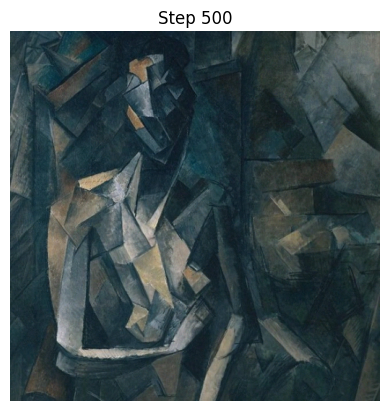

Optimization finished.
Final image saved to: nst_outputs/nst_final.png


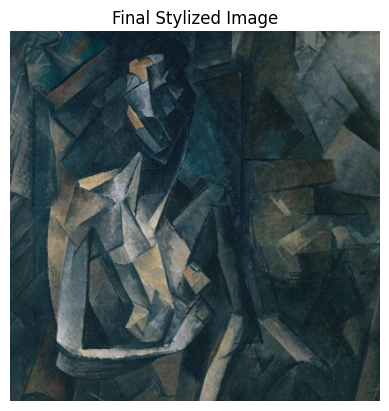

In [ ]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# ---------------------------
# Config
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

content_path_or_url = "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"
style_path_or_url   = "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"

max_size = 512
iters = 500
lr = 0.003
save_every = 100
out_dir = "nst_outputs"
os.makedirs(out_dir, exist_ok=True)

# Utilities: load from URL or local path

def load_image(path_or_url, max_size=None, shape=None):
    # If local file exists, use it; otherwise try to fetch URL
    if os.path.isfile(path_or_url):
        image = Image.open(path_or_url).convert("RGB")
    else:
        resp = requests.get(path_or_url)
        image = Image.open(BytesIO(resp.content)).convert("RGB")

    # Resize
    if shape is not None:
        size = shape
    else:
        if max(image.size) > (max_size or 400):
            size = max_size
        else:
            size = max(image.size)
        size = (size, size)

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    tensor = transform(image).unsqueeze(0)  # shape: (1,3,H,W)
    return tensor

# Denormalize & show/save helpers (we will normalize for VGG)
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

def normalize_batch(tensor):
    # expects tensor in [0,1]
    return (tensor - imagenet_mean.to(tensor.device)) / imagenet_std.to(tensor.device)

def denormalize(tensor):
    img = tensor * imagenet_std.to(tensor.device) + imagenet_mean.to(tensor.device)
    return img

def save_tensor_image(tensor, path):
    # tensor shape: (1,3,H,W) with values in [0,1]
    img = tensor.clone().detach().cpu().squeeze(0)
    img = transforms.ToPILImage()(img)
    img.save(path)

def imshow_tensor(tensor, title=None):
    img = tensor.clone().detach().cpu().squeeze(0)
    plt.imshow(transforms.ToPILImage()(img))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------
# Load content & style (use same shape)
# ---------------------------
content = load_image(content_path_or_url, max_size=max_size).to(device)
style   = load_image(style_path_or_url, shape=content.shape[-2:]).to(device)

# Normalize for VGG input
content_norm = normalize_batch(content)
style_norm   = normalize_batch(style)

# Quick preview (optional)
print("Content shape:", content.shape, "Style shape:", style.shape)
# imshow_tensor(content, "Content")
# imshow_tensor(style, "Style")

# ---------------------------
# VGG19 feature extractor
# ---------------------------
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

# We'll extract the following layers (indices from torchvision vgg19.features):
# mapping: index -> layer name used below
layer_map = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',   # content
    '28': 'conv5_1'
}
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layer = 'conv4_2'

def get_features(x, model):
    features = {}
    out = x
    for name, layer in model._modules.items():
        out = layer(out)
        if name in layer_map:
            features[layer_map[name]] = out
    return features

def gram_matrix(tensor):
    # tensor: (1, C, H, W)
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h*w)
    gram = torch.mm(tensor, tensor.t())
    # normalize by number of elements
    return gram / (c * h * w)

# ---------------------------
# Extract target features (style/content)
# ---------------------------
with torch.no_grad():
    content_feats = get_features(content_norm, vgg)
    style_feats   = get_features(style_norm, vgg)
    style_grams   = {layer: gram_matrix(style_feats[layer]) for layer in style_layers}

# ---------------------------
# Prepare target (start from content)
# ---------------------------
target = content.clone().detach().to(device)
# We'll optimize pixel values directly, so create a normalized version for VGG input inside loop
target.requires_grad_(True)

optimizer = optim.Adam([target], lr=lr)

# Loss weights
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}
content_weight = 1e4
style_weight = 1e2

# ---------------------------
# Optimization loop
# ---------------------------
print("Starting optimization...")
for step in range(1, iters + 1):
    # Compute features on normalized input
    target_norm = normalize_batch(target)
    target_feats = get_features(target_norm, vgg)

    # Content loss
    content_loss = torch.mean((target_feats[content_layer] - content_feats[content_layer]) ** 2)

    # Style loss
    style_loss = 0.0
    for layer in style_layers:
        target_feature = target_feats[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_loss = torch.mean((target_gram - style_gram) ** 2)
        # normalize by channel dimension (optional)
        style_loss += style_weights[layer] * layer_loss

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # clamp pixel range to [0,1] without interfering with autograd (use no_grad)
    with torch.no_grad():
        target.clamp_(0, 1)

    # logging + saving intermediate outputs
    if step % 10 == 0:
        print(f"Step [{step}/{iters}]  Total Loss: {total_loss.item():.4e}")

    if step % save_every == 0 or step == iters:
        out_path = os.path.join(out_dir, f"nst_step_{step}.png")
        save_tensor_image(target.cpu(), out_path)
        print(f"Saved intermediate image: {out_path}")
        # display inline (optional)
        try:
            imshow_tensor(target.cpu(), title=f"Step {step}")
        except Exception:
            pass

print("Optimization finished.")
final_path = os.path.join(out_dir, "nst_final.png")
save_tensor_image(target.cpu(), final_path)
print("Final image saved to:", final_path)
imshow_tensor(target.cpu(), title="Final Stylized Image")
